<a href="https://colab.research.google.com/github/BenHenderson09/H5/blob/main/Bode_criterion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install control > /dev/null

import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

s = ctrl.tf('s')

def g_bar(Kc, tauD):
    """
    Returns the part of G_OL that doesn't have any delays.

    @param Kc: Proportional gain
    @param tauI: Integral time
    @return: Open-loop TF without delays
    """
    # PID controller
    Gc = Kc * (1 + (tauD * s))
    # System (without the delay)
    Gs=(1.151*s+0.1463)/(s*(s**2+0.735*s+1.05015))
    Ga = 1 / (0.0145*s + 1)
    Gm_no_delay = 1 / (0.0021*s + 1)

    # Function Gbar (G_OL without the delay)
    return Gc * Ga * Gm_no_delay * Gs

/usr/local/lib/python3.11/dist-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


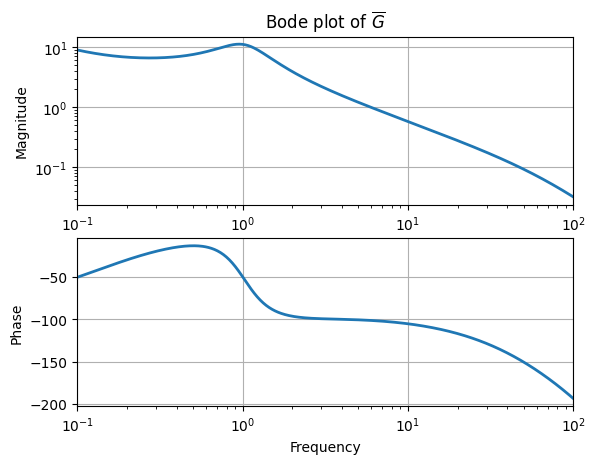

In [ ]:
controller_gain = 5
differential_time = 1
GOL_no_delays = g_bar(controller_gain, differential_time)
delay = 0.0063

# Bode plot
omegas = np.logspace(-1, 2, 500)
m, p, _ = ctrl.bode(GOL_no_delays, omegas, plot=False)
phase_with_delay_degrees = np.rad2deg(p - delay*omegas)

plt.subplot(211)
plt.loglog(omegas, m, linewidth=2)
plt.ylabel('Magnitude')
plt.title('Bode plot of $\overline{G}$')
plt.xlim([0.1, 1e2])

plt.grid(True)

plt.subplot(212)
plt.grid(True)
plt.semilogx(omegas, phase_with_delay_degrees, linewidth=2)
plt.xlim([0.1, 1e2])

plt.ylabel('Phase')
plt.xlabel('Frequency')
plt.show()

In [ ]:
poles=ctrl.poles(GOL_no_delays)
poles

array([-4.76190476e+02+0.j        , -6.89655172e+01+0.j        ,
       -3.67500000e-01+0.95660533j, -3.67500000e-01-0.95660533j,
        0.00000000e+00+0.j        ])

In [ ]:
def plot_cool_bode_plot(
        tf_no_delays,
        controller_gain,
        integral_time,
        delay,
        log_omega_min=-1,
        log_omega_max=2,
        do_plot=True):
   omegas = np.logspace(log_omega_min, log_omega_max, 200)
   omega_min, omega_max = 10**log_omega_min, 10**log_omega_max
   m, p, _ = ctrl.bode(tf_no_delays, omegas, plot=False)
   phase_with_delay_degrees = np.rad2deg(p - delay*omegas)

   n = phase_with_delay_degrees.shape[0]
   for i in range(n):
      if phase_with_delay_degrees[i] < -180:
          break
   omega_crossover = omegas[i]
   gain_at_omega_crossover = m[i]
   if do_plot:
      plt.subplot(211)
      plt.loglog(omegas, m, linewidth=2)
      plt.loglog([omega_crossover, omega_crossover],
          [np.min(m), np.max(m)], 'g--', linewidth=1)
      plt.loglog([omega_min, omega_max],
                  [gain_at_omega_crossover, gain_at_omega_crossover],
                  'g--', linewidth=1)
      plt.xlim([omega_min, omega_max])

      plt.ylabel('Magnitude')
      plt.title('Bode plot of $\overline{G}$')
      plt.grid(True)

      plt.subplot(212)
      plt.grid(True)

      plt.semilogx(omegas, phase_with_delay_degrees, linewidth=2)
      plt.semilogx(omegas, -180 + 0*omegas, 'g--', linewidth=1)
      plt.semilogx([omega_crossover, omega_crossover],
                  [np.min(phase_with_delay_degrees), np.max(phase_with_delay_degrees)],
                  'g--', linewidth=1)

      plt.ylabel('Phase')
      plt.xlabel('Frequency')
      plt.show()

   return omega_crossover, gain_at_omega_crossover

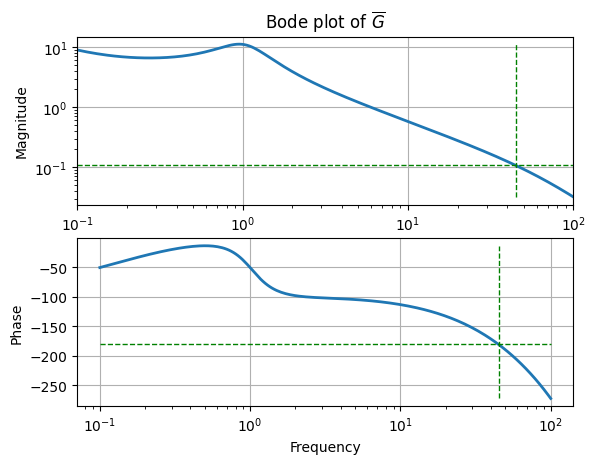

First phrase crossover frequency: 45.01˚
Gain at phase crossover: 0.11 (-19.44dB)


In [ ]:
wco, Kwco = plot_cool_bode_plot(GOL_no_delays, 2, 0.1, 0.02, -1, 2)
print(f'First phrase crossover frequency: {wco:.2f}˚')
print(f'Gain at phase crossover: {Kwco:.2f} ({20*np.log10(Kwco):.2f}dB)')

In [ ]:
def margins(G_no_delay,
            delay,
            log_omega_min=-1,
            log_omega_max=3,
            n_omegas=500,
            k_max=3):
  omega_min, omega_max = 10**log_omega_min, 10**log_omega_max
  omegas = np.logspace(log_omega_min, log_omega_max, n_omegas)
  m, p, _ = ctrl.bode(G_no_delay, omegas, plot=False)
  phase_with_delay_degrees = np.rad2deg(p - delay*omegas)
  # C1. Check whether Gol is stable
  state_space_system = ctrl.ss(G_no_delay)
  A = state_space_system.A
  eigsA = np.real(np.linalg.eig(A)[0])
  assert np.all(eigsA <= 0), "Gol is not stable (one pole at zero allowed)"
  assert np.count_nonzero(eigsA == 0) <= 1, "Multiple poles at zero"
  # C2. we need to determine the phase crossover frequencies
  n = phase_with_delay_degrees.shape[0]
  omega_crossover_found = [False] * k_max
  idx_omega_crossover = [0] * k_max
  for i in range(n):
      for k in range(k_max):
          if not omega_crossover_found[k] and phase_with_delay_degrees[i] < -180 - 360*k:
              omega_crossover_found[k] = True
              idx_omega_crossover[k] = i
  crossovers_found = np.count_nonzero(omega_crossover_found)
  omega_crossovers = omegas[idx_omega_crossover[:crossovers_found]]
  gain_at_omega_crossover_dB = -20*np.log10(m[idx_omega_crossover[:crossovers_found]])
  # C4. The magnitude plot for ω ≥ ωco must be strictly decreasing
  dm = np.diff(m[idx_omega_crossover[0]:])
  assert np.all(dm <= 0)

  gm = gain_at_omega_crossover_dB[0]
  first_omega_crossover = omega_crossovers[0]

  # Determine ωg, i.e., the frequency where |G(j ωg)| = 1
  for i in range(n):
      if np.isclose(m[i], 1, rtol=1e-03):
          wg = omegas[i]
          break
  phi1 = phase_with_delay_degrees[i]
  phase_margin = phi1 + 180
  delay_margin = np.deg2rad(phase_margin) / wg
  out = { "omega_crossovers": omega_crossovers,
          "gain_margin_dB": gm,
          "omega_g": wg,
          "phase_margin": phase_margin,
          "delay_margin": delay_margin }
  return out

In [ ]:
G_no_delay  = g_bar(controller_gain, differential_time)
out = margins(G_no_delay, 0.1, -1, 2, n_omegas=10000)
out

{'omega_crossovers': array([13.24683757, 69.19648092]),
 'gain_margin_dB': np.float64(7.338337555599751),
 'omega_g': np.float64(5.939875985383376),
 'phase_margin': np.float64(46.815541877345964),
 'delay_margin': np.float64(0.13755932764852793)}

In [ ]:
Kmax = 10**(out["gain_margin_dB"]/20)
print(f"Kmax = {Kmax}")
G_no_delay_2  = Kmax * G_no_delay
out2 = margins(G_no_delay_2, 0.1, -1, 2, n_omegas=10000)
out2

Kmax = 0.7273892853079293


{'omega_crossovers': array([13.24683757, 69.19648092]),
 'gain_margin_dB': np.float64(-1.928654933106574e-15),
 'omega_g': np.float64(13.237689227237983),
 'phase_margin': np.float64(0.02264518703361773),
 'delay_margin': np.float64(2.9856651465523325e-05)}

In [ ]:
tmax = out["delay_margin"]
print(f"tmax = {tmax}s")
out3 = margins(G_no_delay, 0.1 + tmax, -1, 2, n_omegas=10000)
out3

tmax = 0.6502952279908197s


{'omega_crossovers': array([ 1.30831304,  9.25543083, 17.82892313]),
 'gain_margin_dB': np.float64(0.00837181837951163),
 'omega_g': np.float64(1.3074095145060398),
 'phase_margin': np.float64(0.0),
 'delay_margin': np.float64(0.0)}